# Data Exploration and Preprocessing

The main objective of this notebook is to explore the data and preprocess it for the further analysis. The data is provided in the form of a CSV file. The data is composed by hourly rental data spanning two years. The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. The goal is to predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

The dataset was obtained from the [Kaggle Bike Sharing Demand competition](https://www.kaggle.com/c/bike-sharing-demand). 

## Library and data import

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import awswrangler as wr
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo

Export the necessary environment variables for working with Minio.

In [2]:
%env AWS_ACCESS_KEY_ID=minio   
%env AWS_SECRET_ACCESS_KEY=minio123 
%env MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
%env AWS_ENDPOINT_URL_S3=http://localhost:9000

env: AWS_ACCESS_KEY_ID=minio
env: AWS_SECRET_ACCESS_KEY=minio123
env: MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
env: AWS_ENDPOINT_URL_S3=http://localhost:9000


Load the data from UCI Machine Learning Repository.

In [3]:
bike_sharing_demand = fetch_ucirepo(id=275)
df_features = bike_sharing_demand.data.features
df_target = bike_sharing_demand.data.targets

# Join the features and target DataFrames
df = pd.concat([df_features, df_target], axis=1)

df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 1.9+ MB


As we can see, the dataset is composed by various columns. Some of them are numerical continuous, others are numerical discrete, and one of them is a datetime column. 

In [5]:
df.isnull().any()

dteday        False
season        False
yr            False
mnth          False
hr            False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
cnt           False
dtype: bool

Fortunately, there are no missing values in the dataset. Then, we can proceed with further analysis.

In [6]:
for column in df.columns:
    print(f'{column} has: {len(df[column].unique()) } unique values')

dteday has: 731 unique values
season has: 4 unique values
yr has: 2 unique values
mnth has: 12 unique values
hr has: 24 unique values
holiday has: 2 unique values
weekday has: 7 unique values
workingday has: 2 unique values
weathersit has: 4 unique values
temp has: 50 unique values
atemp has: 65 unique values
hum has: 89 unique values
windspeed has: 30 unique values
cnt has: 869 unique values


Since, time related features already exist in the dataset, we don't need anymore de `dteday` column. So, we can drop it.

In [7]:
df = df.drop(['dteday'], axis=1)

Next, unique values of the categorical columns are displayed.

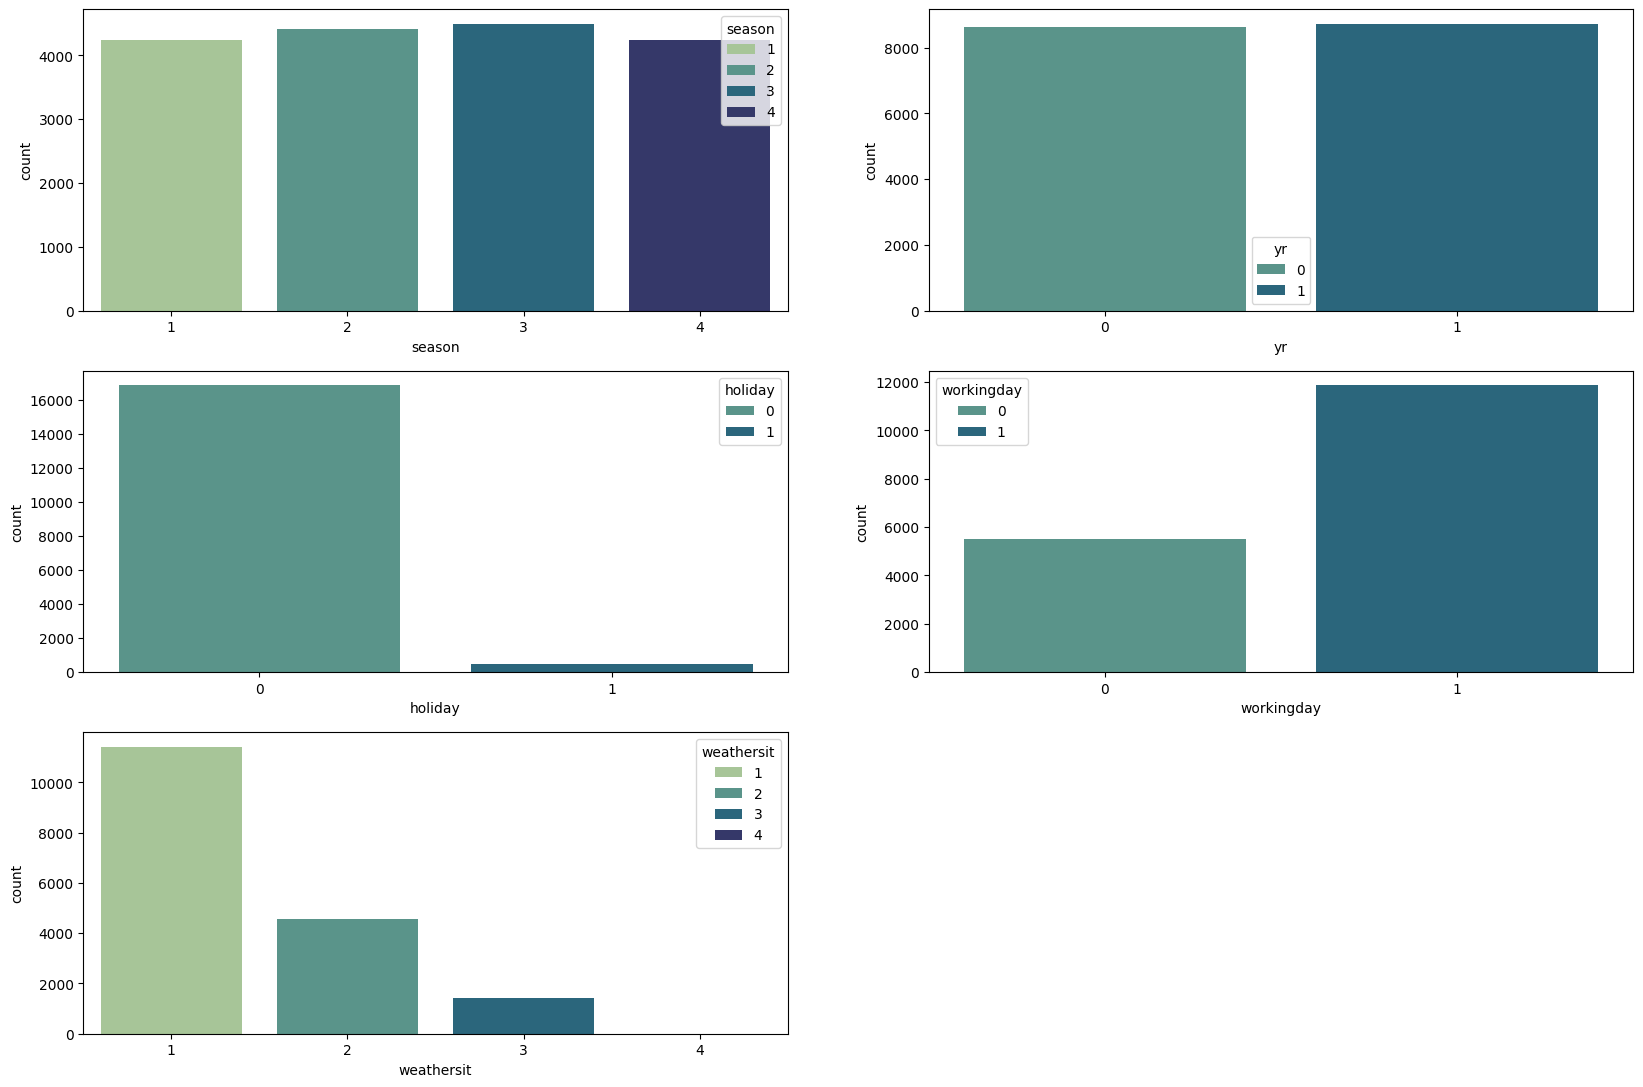

In [8]:
# Configure the size of the plot
plt.figure(figsize=(20,18))

# Initialize the counter
counter = 1

for col in df.columns:
    # Consider only low cardinality columns
    if col not in ['dteday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'hr', 'mnth', 'weekday']:
        plt.subplot(4, 2, counter)
        sns.countplot(x=col, data=df, palette='crest', hue=col)
        counter += 1

# Display the plot
plt.show()

Show the distribution of high cardinality columns

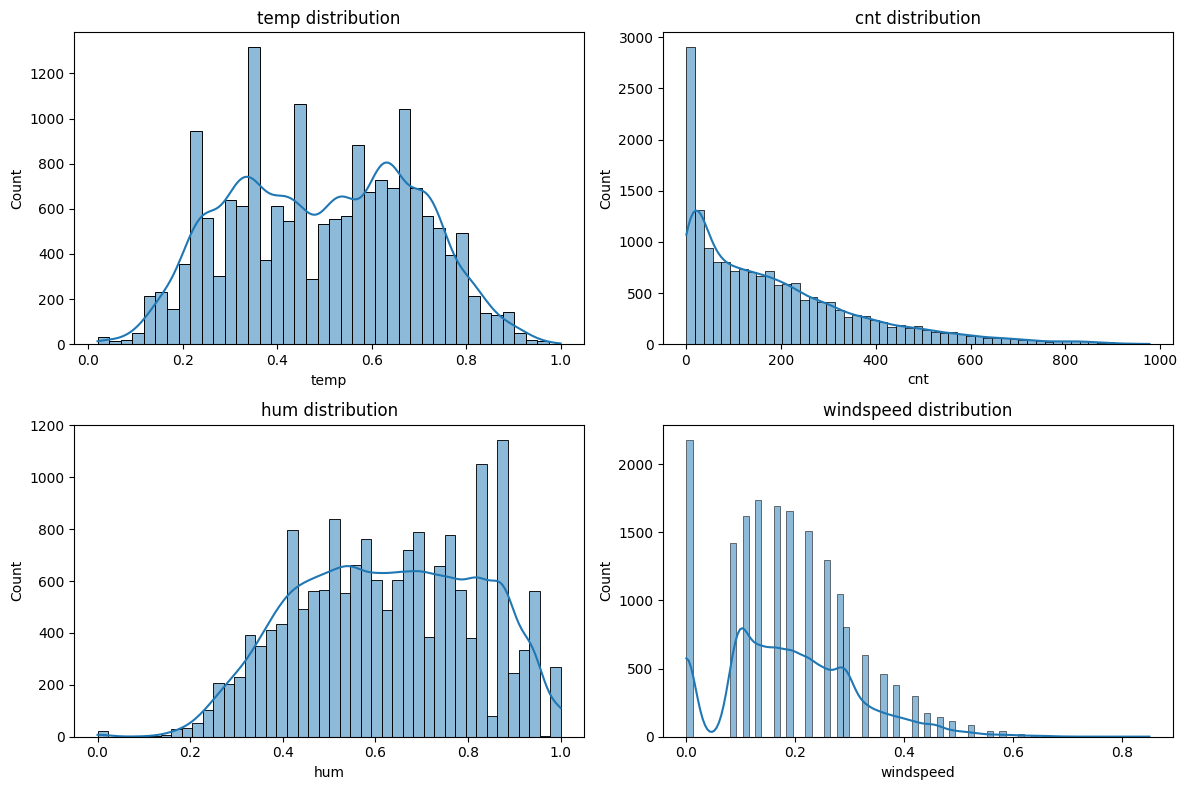

In [9]:
# Configure the size of the plot
plt.figure(figsize=(12, 8))

# Initialize the counter
counter = 1

for col in ['temp', 'cnt', 'hum', 'windspeed']:
    plt.subplot(2, 2, counter)
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} distribution')
    counter += 1

# Adjust layout
plt.tight_layout()
plt.show()

Analyzing the distribution of the columns `cnt`, we can apply a log transformation to them. This will help to normalize its distributions.

In [10]:
df['log_cnt'] = np.log(df['cnt'])

# Drop the cnt column
df = df.drop(['cnt'], axis=1)

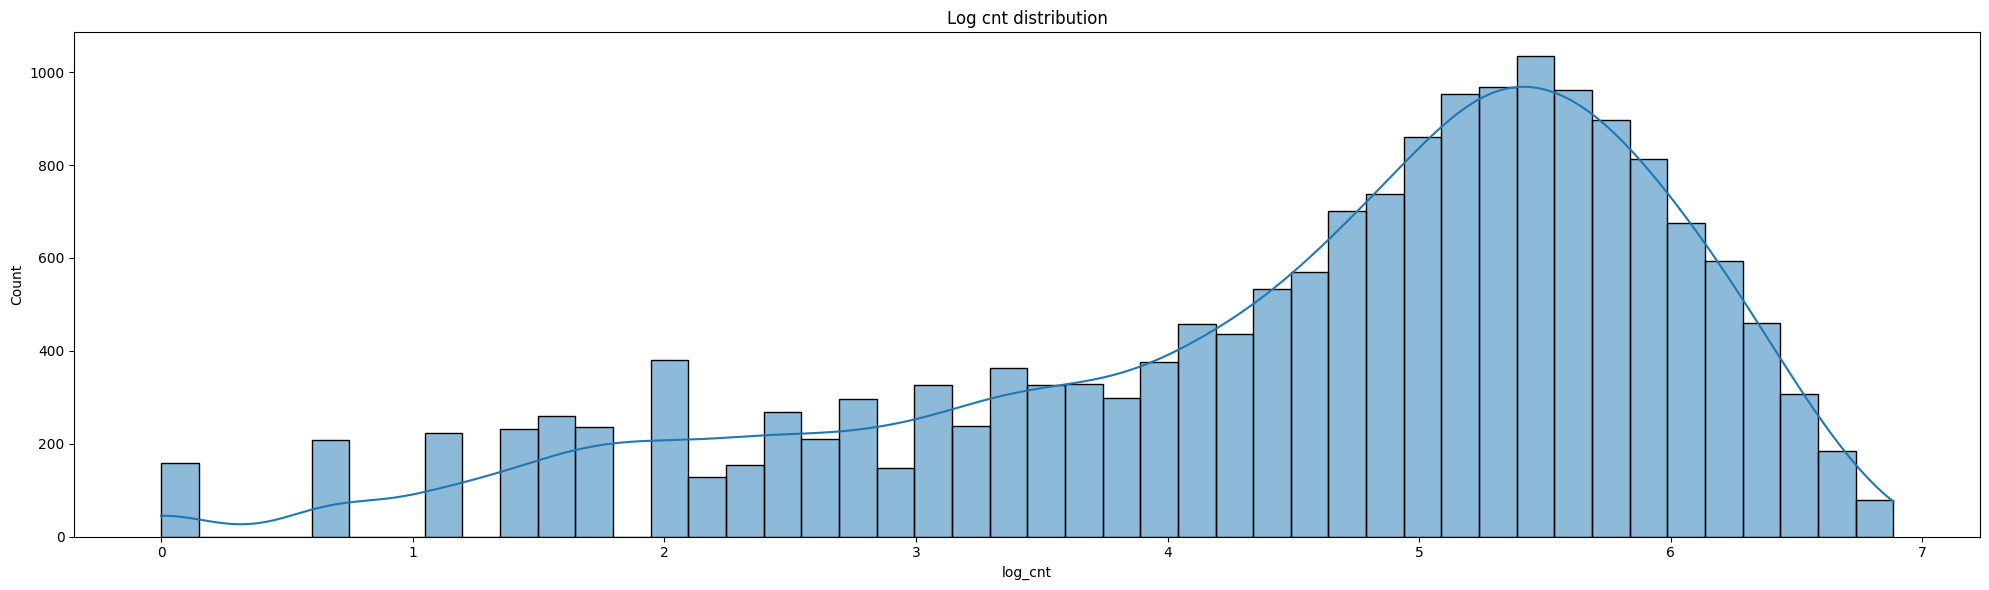

In [11]:
# Configure the size of the plot
plt.figure(figsize=(20, 6))

sns.histplot(df['log_cnt'], kde=True)
plt.title(f'Log cnt distribution')
plt.tight_layout()
plt.show()

In [12]:
df.sample(10)

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,log_cnt
13835,3,1,8,16,0,6,0,1,0.90,0.8182,0.39,0.2985,6.109248
2824,2,0,5,14,0,1,1,1,0.64,0.6061,0.69,0.2239,5.198497
10454,1,1,3,17,0,5,1,3,0.48,0.4697,0.82,0.0896,5.552960
8525,1,0,12,23,1,1,0,1,0.26,0.2727,0.70,0.1045,3.367296
13949,3,1,8,10,0,4,1,1,0.80,0.7576,0.55,0.2239,5.323010
12582,2,1,6,11,0,3,1,2,0.66,0.6212,0.54,0.4478,5.505332
14537,3,1,9,22,0,0,0,3,0.68,0.6364,0.83,0.1343,5.111988
4396,3,0,7,2,0,4,1,1,0.66,0.5909,0.89,0.1940,2.079442
4797,3,0,7,19,0,6,0,2,0.82,0.8030,0.59,0.1343,5.379897
1821,2,0,3,15,0,1,1,2,0.56,0.5303,0.60,0.2239,4.672829


Is important to note that the column `log_cnt` as the target variable, should be transformed back to its original scale after doing predictions with the model.

In [13]:
sample_df = df.copy()
sample_df['log_cnt'] = np.exp(df['log_cnt'])
sample_df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,log_cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16.0
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40.0
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32.0
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13.0
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1.0


As we can see, the reverse transformation is working as expected.

## Correlation Analysis

In order to understand the relationship between the target variable and the features, we can calculate the correlation matrix. This will help to identify the most important features for the model, and also to identify possible multicollinearity issues.

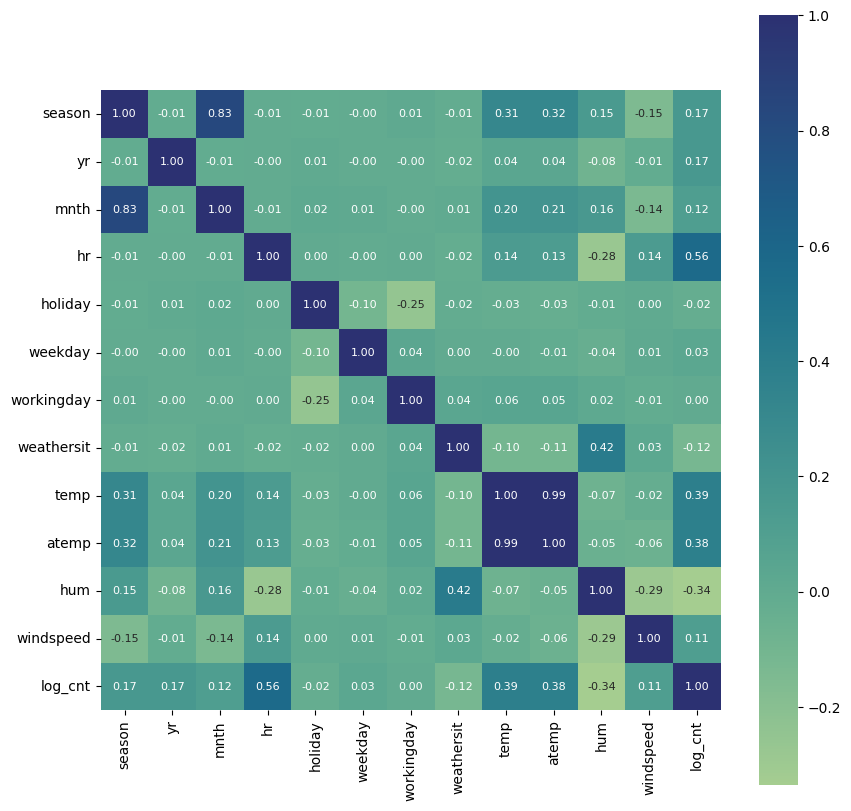

In [14]:
# Calculate the correlation matrix
corr = df.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={'size': 8}, cmap='crest')
plt.show()

We can see that some variables are highly correlated with each other. To avoid multicollinearity, we can drop from this variables, the ones that are less correlated with the target variable `log_cnt`. In this case, we consider high correlation above 0.85.

In [15]:
high_corr_pairs = [
                    # Pair of columns with correlation value
                    (col1, col2) for col1 in corr.columns for col2 in corr.columns 
                    # Ensure the pair is unique and the correlation value is greater than 0.85
                    if col1 != col2 and abs(corr.loc[col1, col2]) > 0.80 
                ]

print(f'Highly correlated pairs: \n{high_corr_pairs}')

Highly correlated pairs: 
[('season', 'mnth'), ('mnth', 'season'), ('temp', 'atemp'), ('atemp', 'temp')]


Determine which variables to drop

In [16]:
to_drop = set()

for col1, col2 in high_corr_pairs:
    # Drop the column with the least correlation with the target
    if abs(corr.loc[col1, 'log_cnt']) > abs(corr.loc[col2, 'log_cnt']):
        to_drop.add(col2)
    else:
        to_drop.add(col1)

# Print the columns that will be dropped
print("Columns to be dropped:", to_drop)

# Drop the identified columns
df = df.drop(columns=to_drop)

df.head()

Columns to be dropped: {'mnth', 'atemp'}


,season,yr,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,log_cnt
0,1,0,0,0,6,0,1,0.24,0.81,0.0,2.772589
1,1,0,1,0,6,0,1,0.22,0.80,0.0,3.688879
2,1,0,2,0,6,0,1,0.22,0.80,0.0,3.465736
3,1,0,3,0,6,0,1,0.24,0.75,0.0,2.564949
4,1,0,4,0,6,0,1,0.24,0.75,0.0,0.000000


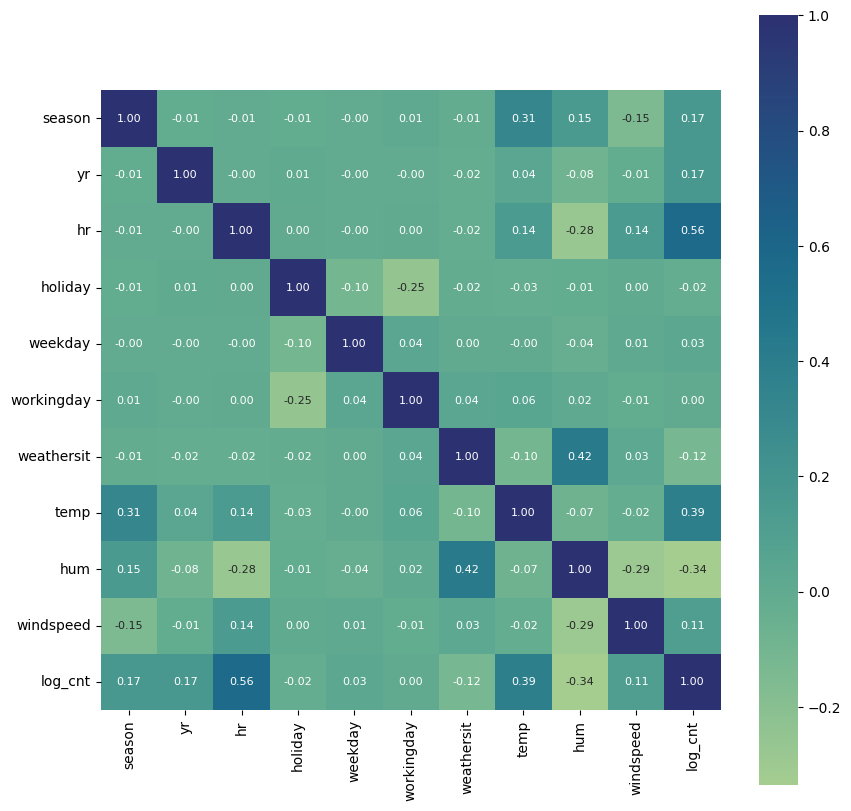

In [17]:
# Calculate the correlation matrix
corr = df.corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={'size': 8}, cmap='crest')
plt.show()

In [18]:
# Get the top 5 columns most correlated with 'count'
top_5_corr = corr['log_cnt'].abs().sort_values(ascending=False).head(6)  # Including 'count' itself

# Drop 'count' from the list
top_5_corr = top_5_corr.drop('log_cnt')

# Display the top 5 columns
print("Top 5 columns most correlated with 'cnt':")
print(top_5_corr)

Top 5 columns most correlated with 'cnt':
hr        0.563126
temp      0.385724
hum       0.335751
season    0.167350
yr        0.165782
Name: log_cnt, dtype: float64


In [19]:
for column in df.columns:
    print(f'{column} has: {len(df[column].unique()) } unique values')

season has: 4 unique values
yr has: 2 unique values
hr has: 24 unique values
holiday has: 2 unique values
weekday has: 7 unique values
workingday has: 2 unique values
weathersit has: 4 unique values
temp has: 50 unique values
hum has: 89 unique values
windspeed has: 30 unique values
log_cnt has: 869 unique values


In [20]:
df.sample(5)

,season,yr,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,log_cnt
1267,1,0,23,0,5,1,1,0.26,0.48,0.3284,3.663562
2505,2,0,7,0,2,1,2,0.52,0.55,0.0000,5.236442
15955,4,1,12,0,5,1,1,0.42,0.41,0.3582,5.676754
5141,3,0,3,0,0,0,2,0.70,0.84,0.1343,3.465736
15413,4,1,10,0,2,1,2,0.44,0.75,0.2239,5.099866


## Variable Encoding

In [21]:
def one_hot_encode(df, one_hot_cols):
    """
    Applies One-Hot Encoding to specified columns of a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    one_hot_cols (list): List of column names to apply One-Hot Encoding to.
    
    Returns:
    pd.DataFrame: The DataFrame with One-Hot Encoded columns.
    """
    # Apply One-Hot Encoding
    df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True, dtype=int)
    return df

In [22]:
def cyclic_encode(df, columns, max_value=23):
    """
    Applies cyclic encoding to specified columns of a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list): List of column names to apply Cyclic Encoding to.
    max_value (int): The maximum value the cyclic variable can take (e.g., 23 for hours).
    
    Returns:
    pd.DataFrame: The DataFrame with Cyclic Encoded columns added.
    """
    for col_name in columns:
        # Compute the sin and cos components
        df[f'{col_name}_sin'] = np.sin(2 * np.pi * df[col_name] / max_value)
        df[f'{col_name}_cos'] = np.cos(2 * np.pi * df[col_name] / max_value)
        # Drop the original column
        df = df.drop(col_name, axis=1)
        
    return df

In [23]:
df_encoded = df.copy()

In [24]:
# Encode using one-hot encoding
df_encoded = one_hot_encode(df_encoded, ['weathersit', 'season', 'weekday'])
# Encode using cyclic encoding
df_encoded = cyclic_encode(df_encoded, ['hr'])

In [25]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            17379 non-null  int64  
 1   holiday       17379 non-null  int64  
 2   workingday    17379 non-null  int64  
 3   temp          17379 non-null  float64
 4   hum           17379 non-null  float64
 5   windspeed     17379 non-null  float64
 6   log_cnt       17379 non-null  float64
 7   weathersit_2  17379 non-null  int64  
 8   weathersit_3  17379 non-null  int64  
 9   weathersit_4  17379 non-null  int64  
 10  season_2      17379 non-null  int64  
 11  season_3      17379 non-null  int64  
 12  season_4      17379 non-null  int64  
 13  weekday_1     17379 non-null  int64  
 14  weekday_2     17379 non-null  int64  
 15  weekday_3     17379 non-null  int64  
 16  weekday_4     17379 non-null  int64  
 17  weekday_5     17379 non-null  int64  
 18  weekday_6     17379 non-nu

## Conclusion

In this notebook, we explored the dataset and performed some preprocessing steps. We dropped the `dteday` column, applied a log transformation to the target variable `cnt`, and dropped some variables that were highly correlated with each other. We also encoded the categorical variables using one-hot encoding.

The variables selected from oringinal dataset are:

In [26]:
selected_features = list(df.columns)

print(f'Selected features: {selected_features}')

Selected features: ['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'log_cnt']
